In [1]:
import sys
import os
import importlib
sys.path.append("/home/jchen/project-8")
import main as exp
from models import SimpleModel
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as F
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import itertools
importlib.reload(exp)

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
def plot_activations(activations, input, gt, pred):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
    axes[0, 0].axis('off')
    axes[0, 2].axis('off')
    axes[0, 1].set_title(f'Input Image, class: {gt}, predicted: {pred}', fontsize=26)
    axes[0, 1].imshow(input[0].permute(1, 2, 0).cpu().numpy())
    axes[0, 1].axis('off')
    for i in range(3):
        act = activations[f'layer{i+1}'][0]
        reshaped_act = act.view(16, 16, 3).cpu().numpy()
        # reshaped_act_norm = (reshaped_act - reshaped_act.min()) / (reshaped_act.max() - reshaped_act.min())
        for j in range(3):
            axes[i+1, j].imshow(reshaped_act[:, :, j], cmap='viridis')
            axes[i+1, j].set_title(f'Layer {i+1} - From {j*256} to {(j+1)*256} tensor', fontsize=26)
            axes[i+1, j].axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
IMG = 64
transformation  = F.Compose([
    F.ToImage(),
    F.ToDtype(torch.float32, scale=True),
    F.Resize(size=(IMG, IMG)),
])

base = dict(n_hidden_layers=3, hidden_d=768, dropout=0.6, lr=8e-4, wd=1e-4)
data_train = ImageFolder("/home/jchen/project-8/data/train", transform=transformation)
data_test = ImageFolder("/home/jchen/project-8/data/val", transform=transformation)

idx_to_class = {v: k for k, v in data_train.class_to_idx.items()}

train_loader = DataLoader(
    data_train, batch_size=1, pin_memory=True, shuffle=False, num_workers=8
)
test_loader = DataLoader(
    data_test, batch_size=1, pin_memory=True, shuffle=False, num_workers=8
)
print(f"Number of training samples: {len(data_train)}")
print(f"Number of test samples: {len(data_test)}")
print(f"Number of classes: {len(data_train.classes)}")
print(f"idx to class mapping: {idx_to_class}")

Number of training samples: 8700
Number of test samples: 2200
Number of classes: 11
idx to class mapping: {0: 'commercial buildings', 1: 'forest_field_jungle', 2: 'home or hotel', 3: 'houses_cabins_gardens_farms', 4: 'industrial and construction', 5: 'mountains_hills_desert_sky', 6: 'shopping and dining', 7: 'sports and leisure', 8: 'sports_fields', 9: 'water_ice_snow', 10: 'workplace'}


In [4]:
model = SimpleModel(
    input_d=3*IMG*IMG,
    hidden_d=base["hidden_d"],
    output_d=11,
    n_hidden_layers=base["n_hidden_layers"],
    dropout=base["dropout"],
    order="linear_bn_act_do",
    input_l2norm=False,
)
model.load_state_dict(torch.load("/home/jchen/project-8/best_test_model_Ndataset_G0_Olinear_bn_act_do_L20.pth"))
model.eval()

# Hook setup
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

In [5]:
print(model)

SimpleModel(
  (backbone): Sequential(
    (0): Linear(in_features=12288, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=768, out_features=768, bias=True)
    (5): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.6, inplace=False)
    (8): Linear(in_features=768, out_features=768, bias=True)
    (9): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): GELU(approximate='none')
    (11): Dropout(p=0.6, inplace=False)
  )
  (output_layer): Linear(in_features=768, out_features=11, bias=True)
)


In [6]:
model.backbone[2].register_forward_hook(get_activation('layer1_gelu'))
model.backbone[6].register_forward_hook(get_activation('layer2_gelu'))
model.backbone[10].register_forward_hook(get_activation('layer3_gelu'))
model.backbone[0].register_forward_hook(get_activation('layer1'))
model.backbone[4].register_forward_hook(get_activation('layer2'))
model.backbone[8].register_forward_hook(get_activation('layer3'))

In [7]:
with torch.no_grad():
    x, y = next(itertools.islice(test_loader, 413, None))
    output = model(x)

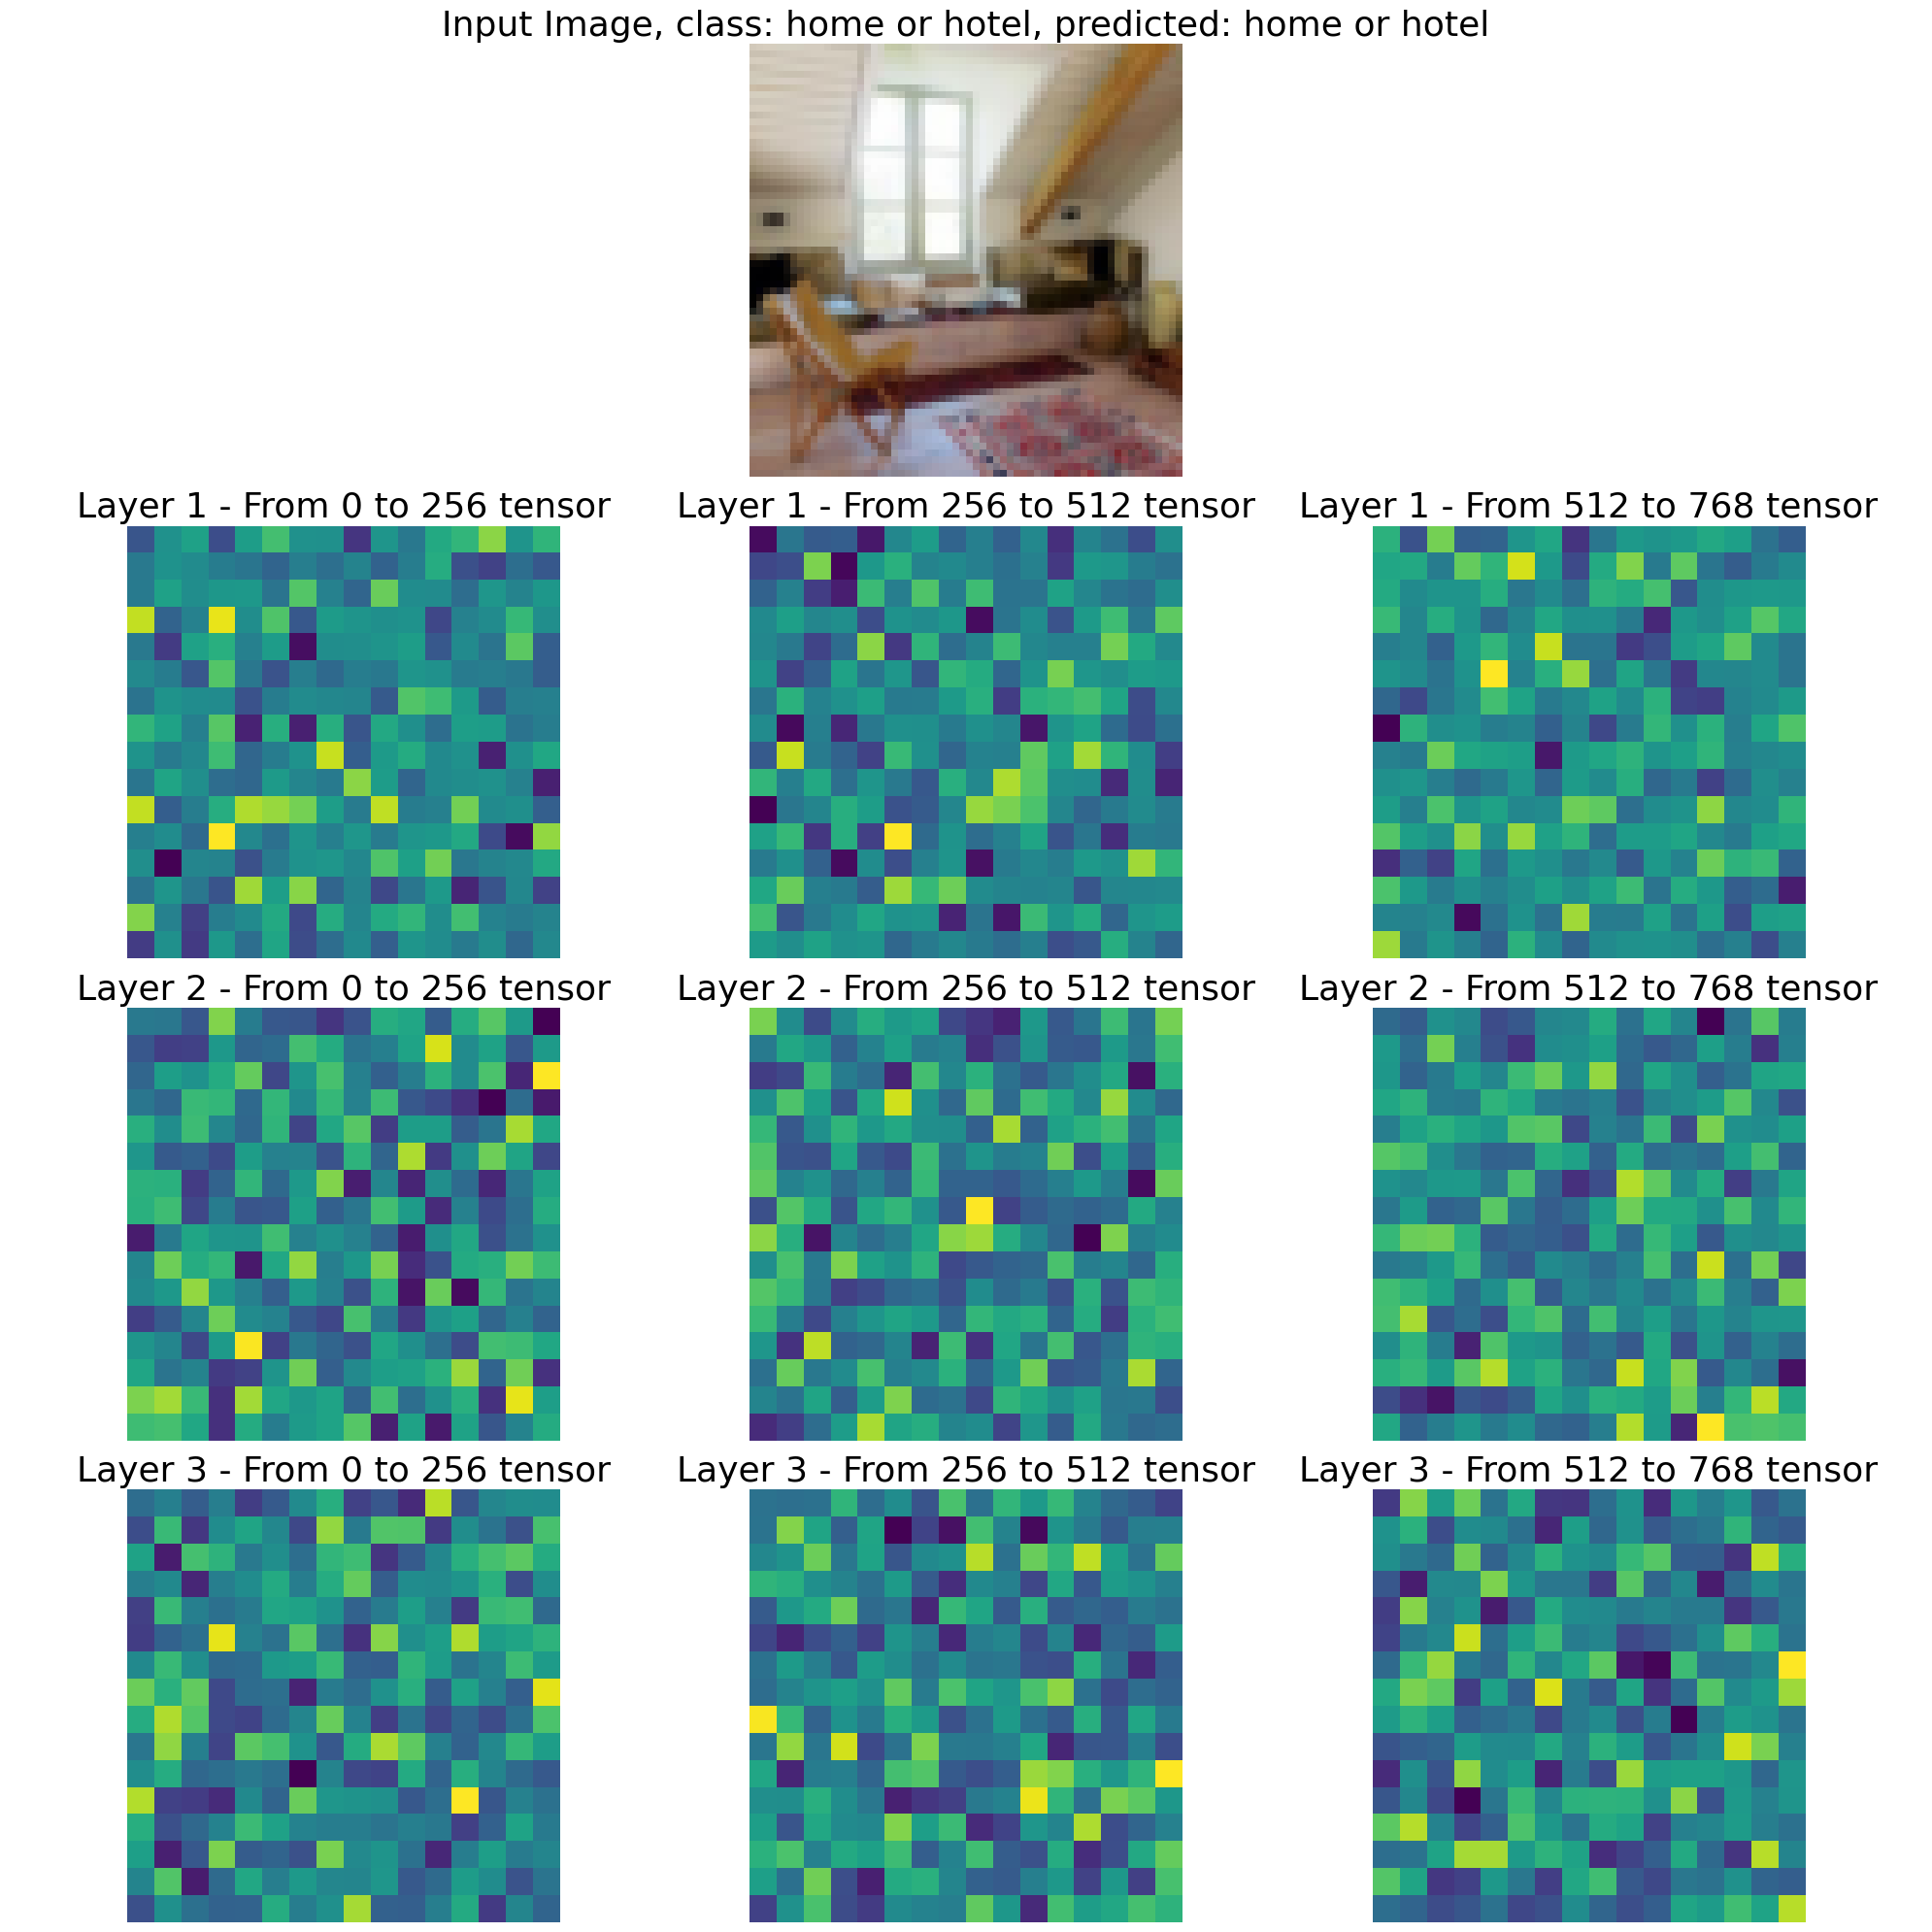

In [8]:
plot_activations(activations, x, idx_to_class[y.item()], idx_to_class[output.argmax(1).item()])

In [9]:
exp.visualize_layer_output(activations['layer1'], 'layer1')
exp.visualize_layer_output(activations['layer2'], 'layer2')
exp.visualize_layer_output(activations['layer3'], 'layer3')
exp.visualize_layer_output(activations['layer1_gelu'], 'layer1_gelu')
exp.visualize_layer_output(activations['layer2_gelu'], 'layer2_gelu')
exp.visualize_layer_output(activations['layer3_gelu'], 'layer3_gelu')

Layer visualization saved as layer1_visualization.png
Layer visualization saved as layer2_visualization.png
Layer visualization saved as layer3_visualization.png
Layer visualization saved as layer1_gelu_visualization.png
Layer visualization saved as layer2_gelu_visualization.png
Layer visualization saved as layer3_gelu_visualization.png
